In [ ]:
import pytest
pytest.importorskip('pycuda')

In [1]:
from pystencils.session import *
sp.init_printing()
frac = sp.Rational

# Phase-field simulation of dentritic solidification in 3D

This notebook tests the model presented in the dentritic growth tutorial in 3D. 

In [2]:
target = ps.Target.GPU
gpu = target == ps.Target.GPU
domain_size = (25, 25, 25) if 'is_test_run' in globals() else (300, 300, 300)

dh = ps.create_data_handling(domain_size=domain_size, periodicity=True, default_target=target)
φ_field = dh.add_array('phi', latex_name='φ')
φ_delta_field = dh.add_array('phidelta', latex_name='φ_D')
t_field = dh.add_array('T')

In [3]:
ε, m, δ, j, θzero, α, γ, Teq, κ, τ = sp.symbols("ε m δ j θ_0 α γ T_eq κ τ")
εb = sp.Symbol("\\bar{\\epsilon}")
discretize = ps.fd.Discretization2ndOrder(dx=0.03, dt=1e-5)

φ = φ_field.center
T = t_field.center
d = ps.fd.Diff

def f(φ, m):
    return φ**4 / 4 - (frac(1, 2) - m/3) * φ**3 + (frac(1,4)-m/2)*φ**2



bulk_free_energy_density = f(φ, m)
interface_free_energy_density = ε ** 2 / 2 * (d(φ, 0) ** 2 + d(φ, 1) ** 2 + d(φ, 2) ** 2)

Here comes the major change, that has to be made for the 3D model: $\epsilon$ depends on the interface normal, which can not be computed simply as atan() as in the 2D case

In [4]:
n = sp.Matrix([d(φ, i) for i in range(3)])
nLen = sp.sqrt(sum(n_i**2 for n_i in n))
n = n / nLen
nVal = sum(n_i**4 for n_i in n)
σ = δ * nVal

εVal = εb * (1 + σ)
εVal

               ⎛  ⎛                            4                              
               ⎜  ⎜                 D(φ[0,0,0])                               
\bar{\epsilon}⋅⎜δ⋅⎜───────────────────────────────────────────── + ───────────
               ⎜  ⎜                                            2              
               ⎜  ⎜⎛           2              2              2⎞    ⎛          
               ⎝  ⎝⎝D(φ[0,0,0])  + D(φ[0,0,0])  + D(φ[0,0,0]) ⎠    ⎝D(φ[0,0,0]

                 4                                               4            
      D(φ[0,0,0])                                     D(φ[0,0,0])             
────────────────────────────────── + ─────────────────────────────────────────
                                 2                                            
 2              2              2⎞    ⎛           2              2             
)  + D(φ[0,0,0])  + D(φ[0,0,0]) ⎠    ⎝D(φ[0,0,0])  + D(φ[0,0,0])  + D(φ[0,0,0]

    ⎞    ⎞
    ⎟    ⎟
────⎟ + 1⎟
   2⎟    ⎟
 2⎞ ⎟ 

In [5]:
def m_func(temperature):
    return (α / sp.pi) * sp.atan(γ * (Teq - temperature))

In [6]:
substitutions = {m: m_func(T),
                 ε: εVal}

fe_i = interface_free_energy_density.subs(substitutions)
fe_b = bulk_free_energy_density.subs(substitutions)

μ_if = ps.fd.expand_diff_full(ps.fd.functional_derivative(fe_i, φ), functions=[φ])
μ_b = ps.fd.expand_diff_full(ps.fd.functional_derivative(fe_b, φ), functions=[φ])

In [7]:
dF_dφ = μ_b + sp.Piecewise((μ_if, nLen**2 > 1e-10), (0, True))

In [8]:
parameters = {
    τ: 0.0003,
    κ: 1.8,
    εb: 0.01,
    δ: 0.3,
    γ: 10,
    j: 6,
    α: 0.9,
    Teq: 1.0,
    θzero: 0.2,
    sp.pi: sp.pi.evalf()
}
parameters

In [9]:
dφ_dt = - dF_dφ / τ
assignments = [
    ps.Assignment(φ_delta_field.center, discretize(dφ_dt.subs(parameters))),
]
φEqs = ps.simp.sympy_cse_on_assignment_list(assignments)
φEqs.append(ps.Assignment(φ, discretize(ps.fd.transient(φ) - φ_delta_field.center)))


temperatureEvolution = -ps.fd.transient(T) + ps.fd.diffusion(T, 1) + κ * φ_delta_field.center
temperatureEqs = [
    ps.Assignment(T, discretize(temperatureEvolution.subs(parameters)))
]

In [10]:
temperatureEqs

[T_C := 0.0111111111111111⋅T_W + 0.0111111111111111⋅T_S + 0.0111111111111111⋅T
_B + 0.933333333333333⋅T_C + 0.0111111111111111⋅T_T + 0.0111111111111111⋅T_N +
 0.0111111111111111⋅T_E + 1.8e-5⋅phidelta_C]

In [11]:
φ_kernel = ps.create_kernel(φEqs, cpu_openmp=4, target=target).compile()
temperatureKernel = ps.create_kernel(temperatureEqs, cpu_openmp=4, target=target).compile()

In [12]:
def time_loop(steps):
    φ_sync = dh.synchronization_function(['phi'], target=target)
    temperature_sync = dh.synchronization_function(['T'], target=target)
    dh.all_to_gpu()
    for t in range(steps):
        φ_sync()
        dh.run_kernel(φ_kernel)
        temperature_sync()
        dh.run_kernel(temperatureKernel)
    dh.all_to_cpu()


def init(nucleus_size=np.sqrt(5)):
    for b in dh.iterate():
        x, y, z = b.cell_index_arrays
        x, y, z = x - b.shape[0] // 2, y - b.shape[1] // 2, z - b.shape[2] // 2
        b['phi'].fill(0)
        b['phi'][(x ** 2 + y ** 2 + z ** 2) < nucleus_size ** 2] = 1.0
        b['T'].fill(0.0)


def plot(slice_obj=ps.make_slice[:, :, 0.5]):
    plt.subplot(1, 3, 1)
    plt.scalar_field(dh.gather_array('phi', slice_obj).squeeze())
    plt.title("φ")
    plt.colorbar()
    plt.subplot(1, 3, 2)
    plt.title("T")
    plt.scalar_field(dh.gather_array('T', slice_obj).squeeze())
    plt.colorbar()
    plt.subplot(1, 3, 3)
    plt.title("∂φ")
    plt.scalar_field(dh.gather_array('phidelta', slice_obj).squeeze())
    plt.colorbar()

    Name|      Inner (min/max)|     WithGl (min/max)
----------------------------------------------------
       T|            (  0,  0)|            (  0,  0)
     phi|            (  0,  1)|            (  0,  1)
phidelta|            (  0,  0)|            (  0,  0)



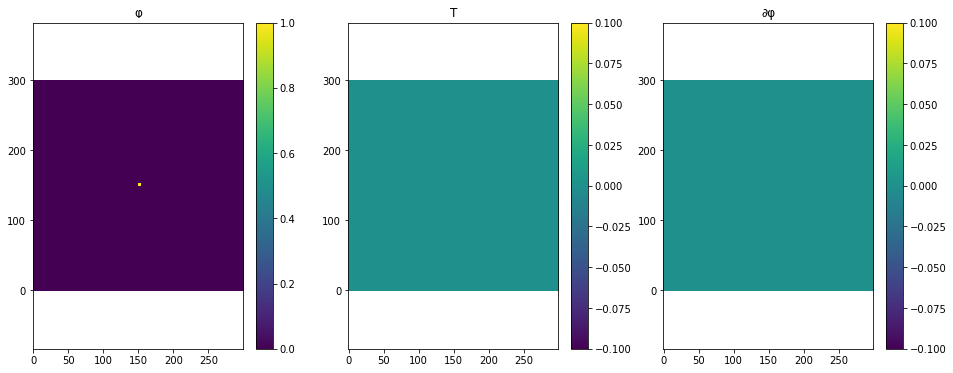

In [13]:
init()
plot()
print(dh)

In [ ]:
if 'is_test_run' in globals():
    time_loop(2)
    assert np.isfinite(dh.max('phi'))
    assert np.isfinite(dh.max('T'))
    assert np.isfinite(dh.max('phidelta'))
else:
    from time import perf_counter
    vtk_writer = dh.create_vtk_writer('dentritic_growth_large', ['phi'])
    last = perf_counter()
    for i in range(300):
        time_loop(100)
        vtk_writer(i)
        print("Step ", i, perf_counter() - last, dh.max('phi'))
        last = perf_counter()